# A Study of Image Classification using Dog Breed Data and AWS Sagemaker

We present the code and findings of the project of "Image Classification using Dog Breed Data and AWS Sagemaker" through this notebook. We will start by downloading the dog breed dataset. Then the dog breed data are uploaded to S3 bucket using the AWS Gateway. The next step performed is fine tuning the model by defing the the four hyperparameters for tuning. In this project, we will use the pretrained Resnet 50 model. 
The next task of the project moves head with  profiling and debugging new model using Sagemaker and then end the project with deploying the model and further analysis.

In [2]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
  Using cached smdebug-1.0.12-py2.py3-none-any.whl (270 kB)
  Using cached pyinstrument-3.4.2-py2.py3-none-any.whl (83 kB)
  Using cached pyinstrument_cext-0.2.4-cp37-cp37m-manylinux2010_x86_64.whl (20 kB)


In [149]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3
from sagemaker.session import Session
from sagemaker import get_execution_role
# Initializing some useful variables
role = get_execution_role()
sagemaker_session = sagemaker.Session()
rgn = sagemaker_session.boto_region_name
bucket = sagemaker_session.default_bucket()
print(f"The region is {rgn}")
print(f"The default S3 bucket used is : {bkt}")
print(role)
print(bucket)

The region is us-east-1
The default S3 bucket used is : sagemaker-us-east-1-074088775525
arn:aws:iam::074088775525:role/service-role/AmazonSageMaker-ExecutionRole-20211229T201910
sagemaker-us-east-1-074088775525


## Dataset
The dog breed data provided by the udacity course in the project overview page of this part of court is used in this projects. The data has images of 133 breeds of dogs which are divided inot training test and validation datasets.

In [5]:
#TODO: Fetch and upload the data to AWS S3
# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

--2022-01-05 07:33:47--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.121.88
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.121.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

dogImages.zip       100%[===================>]   1.05G  17.9MB/s    in 38s     

2022-01-05 07:34:26 (28.7 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]

Archive:  dogImages.zip
   creating: dogImages/
   creating: dogImages/test/
   creating: dogImages/train/
   creating: dogImages/valid/
   creating: dogImages/test/001.Affenpinscher/
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg  
  inflating: dogImages/test/001.Af

## Uploading the dog breed data to S3 object
Now, let us upload the dog images data to the S3 bucket.

In [6]:
# defining path
inp_path = sagemaker_session.upload_data(path="dogImages",bucket = bkt, key_prefix = "dogImagesData")
print("The dog breed data is uploaded to:",inp_path)

The dog breed data is uploaded to: s3://sagemaker-us-east-1-074088775525/dogImagesData


## Hyperparameter Tuning
Now as the next part of the project we will finetune ResNet model with hyperparameter tuning. We decided to fine tune four hyperparameters. 
The four hyper parameters fine tuned are as below:
1)eps  which is a conitnuous hyper parameter is fine tuned in (1e-8, 1e-5)
2)Learning rate, which is also a continuous hyper parameter is fine tuned in (0.0001, 0.05)
3)weight_decay is also an continuous hyper parameter is finetuned in (1e-3, 1e1)
4)Batch size is the categorical hyper parameter and is fine tuned in[64,128,512]

Among the hyperparameters tuned, batch size and learning rate have the highest impact on teh image classification task. The hyperparameter tuned here are in general considered by the researcher for tuning to get the best fit model in the image classification problem.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [7]:
#Let's declare your the hyper-parameter ranges and metrics etc.
from sagemaker.tuner import (
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner
)

#As described previously, we will fine tune the four hyperparameters as below.
hyperparameter_ranges = {
   
    "eps": ContinuousParameter(1e-8, 1e-5),
     "lr": ContinuousParameter(0.0001, 0.05),
    "weight_decay": ContinuousParameter(1e-3, 1e-1),
    "batch_size": CategoricalParameter([ 64, 128,512]),

}
objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

In [8]:
#TODO: Create estimators for your HPs

from  sagemaker.pytorch import PyTorch

estimator = PyTorch(
    entry_point = "hpo.py",
    base_job_name = "dog-breed-classification-hpo",
    role = role,
    instance_count = 1,
    instance_type = "ml.g4dn.xlarge",
    py_version = "py36",
    framework_version = "1.8"
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=2,
    objective_type=objective_type, 
    early_stopping_type="Auto"
)

In [10]:
# TODO: Fit your HP Tuner
input_path = "s3://sagemaker-us-east-1-074088775525/dogImagesData/"
tuner.fit({"training": input_path }, wait=True)

........................................................................................................................................................................................................................................................................!


In [11]:
# TODO: Get the best estimators and the best HPs

best_estimator =  tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2022-01-05 08:26:07 Starting - Preparing the instances for training
2022-01-05 08:26:07 Downloading - Downloading input data
2022-01-05 08:26:07 Training - Training image download completed. Training in progress.
2022-01-05 08:26:07 Stopping - Stopping the training job early
2022-01-05 08:26:07 Uploading - Uploading generated training model
2022-01-05 08:26:07 Stopped - Training job stopped

Job ended with status 'Stopped' rather than 'Completed'. This could mean the job timed out or stopped early for some other reason: Consider checking whether it completed as you expect.


{'_tuning_objective_metric': '"average test loss"',
 'batch_size': '"128"',
 'eps': '1.0925244483258367e-06',
 'lr': '0.0005732799338278194',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"dog-breed-classification-hpo-2022-01-05-08-03-44-211"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-074088775525/dog-breed-classification-hpo-2022-01-05-08-03-44-211/source/sourcedir.tar.gz"',
 'weight_decay': '0.002447556100871492'}

In [13]:
best_hyperparameters={'batch_size': int(best_estimator.hyperparameters()['batch_size'].replace('"', "")),
                      'eps': best_estimator.hyperparameters()['eps'],
                      'lr': best_estimator.hyperparameters()['lr'],
                      'weight_decay': best_estimator.hyperparameters()['weight_decay'],}
print('The best hyperparameters fine tuned are:', best_hyperparameters)

The best hyperparameters fine tuned are: {'batch_size': 128, 'eps': '1.0925244483258367e-06', 'lr': '0.0005732799338278194', 'weight_decay': '0.002447556100871492'}


## Model Profiling and Debugging
In this stage of the project we will create and fine tune a new model using the best hyperparameters obtained from previous fine tuning.

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [14]:
# TODO: Set up debugging and profiling rules and hooks
# Setting up debugger and profiler rules and configs
from sagemaker.debugger import (
    Rule,
    rule_configs, 
    ProfilerRule,
    DebuggerHookConfig,
    CollectionConfig,
    ProfilerConfig,
    FrameworkProfile
)


rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)

collection_configs=[CollectionConfig(name="CrossEntropyLoss_output_0",parameters={
    "include_regex": "CrossEntropyLoss_output_0", "train.save_interval": "10","eval.save_interval": "1"})]

debugger_config=DebuggerHookConfig( collection_configs=collection_configs )

In [15]:
# TODO: Create and fit an estimator

estimator = PyTorch(
    entry_point="train_model.py",
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    role=role,
    framework_version="1.6", #using 1.6 as it has support for smdebug lib , https://github.com/awslabs/sagemaker-debugger#debugger-supported-frameworks
    py_version="py36",
    hyperparameters=best_hyperparameters,
    profiler_config=profiler_config, # include the profiler hook
    debugger_hook_config=debugger_config, # include the debugger hook
    rules=rules
)

estimator.fit({'train' : input_path },wait=True)

2022-01-05 08:33:47 Starting - Starting the training job...
2022-01-05 08:34:15 Starting - Launching requested ML instancesVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
......
2022-01-05 08:35:15 Starting - Preparing the instances for training.........
2022-01-05 08:36:40 Downloading - Downloading input data.........
2022-01-05 08:38:18 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-01-05 08:38:18,988 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-01-05 08:38:19,008 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-01-05 08:38:19,226 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-01-05 08:38:19,604 sagemaker-training-toolkit INFO    

[2022-01-05 08:52:32.955 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:18 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-01-05 08:52:33.009 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:18 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-074088775525/pytorch-training-2022-01-05-08-33-46-597/debug-output
[2022-01-05 08:52:35.807 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:18 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2022-01-05 08:52:36.836 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:18 INFO trial.py:210] Loaded all steps


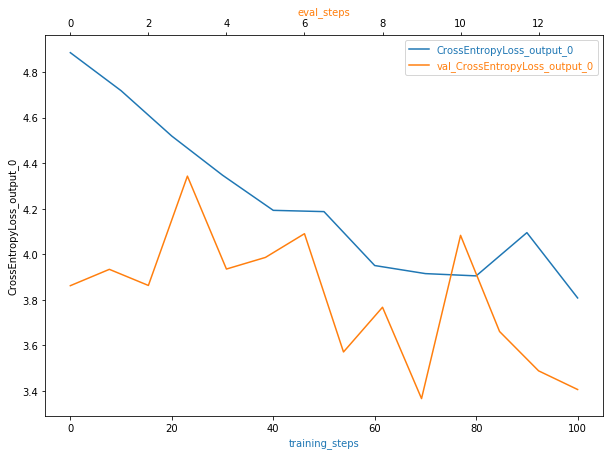

In [16]:
# TODO: Plot a debugging output.

# Let us start by extracting jobname, client and description that are required for plotting
job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)

# Define a Trail
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())


## Plotting
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot

#utility function to get data from tensors
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

#plot tensor utility functions for plotting tensors
def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("training_steps")
    par.set_xlabel("eval_steps")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)
    plt.show()
plot_tensor(trial, "CrossEntropyLoss_output_0")

Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
The output is not as smooth as expected. Adding the layers in the pretrained model can help to make it smooth.

In [17]:
# TODO: Display the profiler output
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"

In [18]:
! aws s3 ls {rule_output_path} --recursive

2022-01-05 08:43:41     370684 pytorch-training-2022-01-05-08-33-46-597/rule-output/ProfilerReport/profiler-output/profiler-report.html
2022-01-05 08:43:40     219006 pytorch-training-2022-01-05-08-33-46-597/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2022-01-05 08:43:35        191 pytorch-training-2022-01-05-08-33-46-597/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2022-01-05 08:43:35      16410 pytorch-training-2022-01-05-08-33-46-597/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2022-01-05 08:43:35        126 pytorch-training-2022-01-05-08-33-46-597/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2022-01-05 08:43:35        129 pytorch-training-2022-01-05-08-33-46-597/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2022-01-05 08:43:35       5121 pytorch-training-2022-01-05-08-33-46-597/rule-output/ProfilerReport/profiler-output/profiler-re

In [19]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-074088775525/pytorch-training-2022-01-05-08-33-46-597/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-074088775525/pytorch-training-2022-01-05-08-33-46-597/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-us-east-1-074088775525/pytorch-training-2022-01-05-08-33-46-597/rule-output/ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json to ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json
download: s3://sagemaker-us-east-1-074088775525/pytorch-training-2022-01-05-08-33-46-597/rule-output/ProfilerReport/profiler-output/profiler-report.html to ProfilerReport/profiler-output/profiler-report.html
download: s3://sagemaker-us-east-1-074088775525/pytorch-training-2022-01-05-08-33-46-597

In [20]:
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [21]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

In [114]:
# TODO: Deploy your model to an endpoint

predictor = estimator.deploy(initial_instance_count=1, instance_type="ml.m5.xlarge")

-----!

In [151]:
from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor

#Below is the s3 location of our saved model that was trained by the training job using the best hyperparameters
model_data_artifacts = "s3://sagemaker-us-east-1-074088775525/pytorch-training-2022-01-05-13-15-36-614/model.tar.gz"

#We need to define the serializer and deserializer that we will be using as default for our Prediction purposes
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()

#If we need to override the serializer and deserializer then we need to pass them in an class inheriting the Predictor class and pass this class as parameter to our PyTorchModel
class ImgPredictor(Predictor):
    def __init__( self, endpoint_name, sagemaker_session):
        super( ImgPredictor, self).__init__(
            endpoint_name,
            sagemaker_session = sagemaker_session,
            serializer = jpeg_serializer,
            deserializer = json_deserializer
        )
        
pytorch_model = PyTorchModel( model_data = model_data_artifacts,
                            role = role,
                             entry_point= "endpoint_inference.py",
                             py_version = "py36",
                             framework_version = "1.6",
                            predictor_cls = ImgPredictor
                            )

predictor = pytorch_model.deploy( initial_instance_count = 1, instance_type = "ml.t2.medium")

----------!

In [152]:
endpoint_name= predictor.endpoint_name

Test image no: 1
Image to be tested:


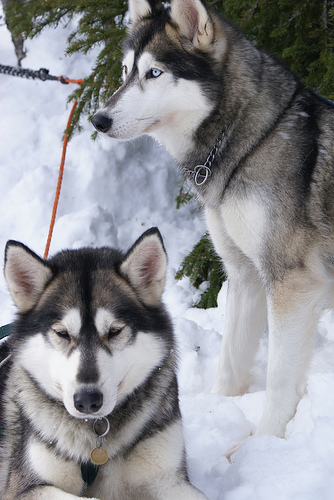

Dog breed expected: 5
Response: [[0.         0.         0.         0.         0.         0.
  0.         0.         0.         2.30793715 1.04663908 0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.10435658 0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         2.62522912 0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.26022881 0.
  0.    

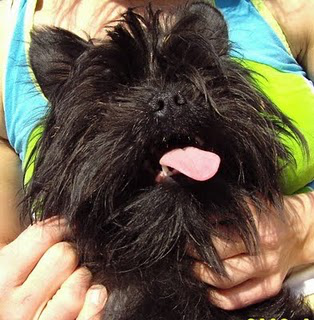

Dog breed expected: 1
Response: [[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.35419506
  0.         0.48174202 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.89428747 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         1.82116199 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.


In [158]:

# Using the runtime boto3 client to test the deployed models endpoint
import os
import io
import boto3
import json
import base64
import PIL

# get the endpoint name
ENDPOINT_NAME = endpoint_name

runtime= boto3.client('runtime.sagemaker')
test_dir = "./test_images"
test_images = [ 'Alaskan_malamute_00309.jpg','Affenpinscher_00003.jpg' ]
test_images_expected_output = [5,1]
for index in range(len(test_images) ):
    test_img = test_images[index]
    expected_breed_category = test_images_expected_output[index]
    print(f"Test image no: {index+1}")
    test_file_path = os.path.join(test_dir,test_img)
    with open(test_file_path , "rb") as f:
        payload = f.read()
        print("Image to be tested:")
        display(Image.open(io.BytesIO(payload)))
        print(f"Dog breed expected: {expected_breed_category}")
        response = runtime.invoke_endpoint(EndpointName=ENDPOINT_NAME,
                                       ContentType='image/jpeg',
                                       Body=payload)
        response_body = np.asarray(json.loads( response['Body'].read().decode('utf-8')))        
        print(f"Response: {response_body}")        
        predicted_dog_breed = np.argmax(response_body,1) + 1 
        print(f"Response/Inference for the above image is : {predicted_dog_breed}")

In [159]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()